## 📘 **Notebook 02 – Building and Training CNN & VGG16 Models**


In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, applications
import matplotlib.pyplot as plt
import os

In [2]:
# ✅ Vérification GPU disponible
physical_devices = tf.config.list_physical_devices('GPU')
print(f"✅ GPU détecté : {len(physical_devices)} disponible(s)")
if len(physical_devices) > 0:
    print("💡 TensorFlow utilisera le GPU pour accélérer l'entraînement.")
else:
    print("⚠️ Aucun GPU détecté : l'entraînement sera effectué sur CPU (plus lent).")

✅ GPU détecté : 1 disponible(s)
💡 TensorFlow utilisera le GPU pour accélérer l'entraînement.


In [3]:
# 📁 Paramètres
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 30
MODEL_PATH_CNN = "models/cnn_model.h5"
MODEL_PATH_VGG = "models/vgg16_model.h5"

In [4]:
# 🧪 Chargement des générateurs (à exécuter après le preprocessing)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

SPLIT_DATA_PATH = "data/split"

val_test_datagen = ImageDataGenerator(rescale=1./255)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    os.path.join(SPLIT_DATA_PATH, 'train'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    os.path.join(SPLIT_DATA_PATH, 'val'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 37996 images belonging to 38 classes.
Found 8129 images belonging to 38 classes.


### 🧠 **1. Custom CNN Model**  


In [5]:
model_cnn = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

model_cnn.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
model_cnn.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 64)     256       
 hNormalization)                                                 
                                                        

**📦 Callbacks**


In [6]:
checkpoint_cnn = callbacks.ModelCheckpoint(MODEL_PATH_CNN, save_best_only=True)
earlystop_cb = callbacks.EarlyStopping(patience=5, restore_best_weights=True)

**🚀 Train the CNN model**  


In [7]:
history_cnn = model_cnn.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[checkpoint_cnn, earlystop_cb]
)

Epoch 1/30
1188/1188 [==============================] - 706s 590ms/step - loss: 3.7810 - accuracy: 0.1735 - val_loss: 3.0803 - val_accuracy: 0.1696
Epoch 2/30
1188/1188 [==============================] - 407s 343ms/step - loss: 3.0832 - accuracy: 0.2040 - val_loss: 2.8216 - val_accuracy: 0.2517
Epoch 3/30
1188/1188 [==============================] - 389s 327ms/step - loss: 2.9725 - accuracy: 0.2227 - val_loss: 2.6921 - val_accuracy: 0.2927
Epoch 4/30
1188/1188 [==============================] - 373s 314ms/step - loss: 2.9034 - accuracy: 0.2421 - val_loss: 2.4778 - val_accuracy: 0.3184
Epoch 5/30
1188/1188 [==============================] - 373s 314ms/step - loss: 2.8796 - accuracy: 0.2404 - val_loss: 2.7889 - val_accuracy: 0.3031
Epoch 6/30
1188/1188 [==============================] - 372s 313ms/step - loss: 2.8097 - accuracy: 0.2493 - val_loss: 2.4725 - val_accuracy: 0.3162
Epoch 7/30
1188/1188 [==============================] - 372s 313ms/step - loss: 2.7346 - accuracy: 0.2684 - val_

**📊 CNN Learning Curves**


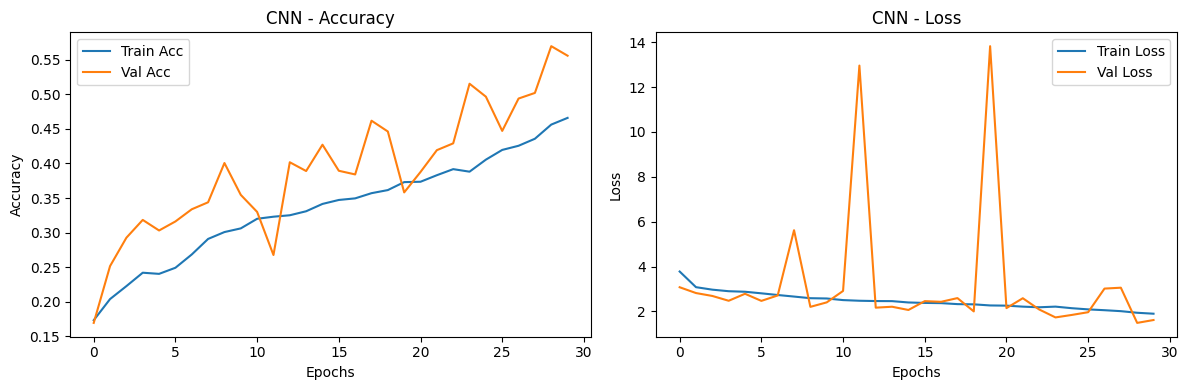

✅ CNN model successfully trained and saved.


In [36]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'], label='Train Acc')
plt.plot(history_cnn.history['val_accuracy'], label='Val Acc')
plt.title('CNN - Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'], label='Train Loss')
plt.plot(history_cnn.history['val_loss'], label='Val Loss')
plt.title('CNN - Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

print("✅ CNN model successfully trained and saved.")


### 🏛️ **2. VGG16 Model**  


🔧 **Load the VGG16 base pre-trained on ImageNet**  


In [12]:
# "On enlève les couches denses finales (include_top=False) pour ajouter notre propre tête personnalisée."
vgg_base = applications.VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
vgg_base.trainable = False  # On freeze toutes les couches convolutionnelles pour ne pas les réentraîner


🔨 **Add a custom dense head: pooling, dense, dropout, softmax**  


In [13]:
model_vgg = models.Sequential([
    vgg_base,
    layers.GlobalAveragePooling2D(),  # Transforme les maps 3D en vecteur 1D
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(train_generator.num_classes, activation='softmax')  # Sortie multiclasse
])

model_vgg.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
model_vgg.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 38)                9766      
                                                                 
Total params: 14,855,782
Trainable params: 141,094
Non-trainable params: 14,714,688
____________________________________

📦 **Callback to save only the best model weights**  


In [14]:
checkpoint_vgg = callbacks.ModelCheckpoint(MODEL_PATH_VGG, save_best_only=True)

🚀 **Train the VGG16 model (dense head only)**  


In [15]:
history_vgg = model_vgg.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[checkpoint_vgg, earlystop_cb]
)


Epoch 1/30
1188/1188 [==============================] - 484s 395ms/step - loss: 1.7667 - accuracy: 0.5113 - val_loss: 0.8733 - val_accuracy: 0.7445
Epoch 2/30
1188/1188 [==============================] - 430s 362ms/step - loss: 0.9919 - accuracy: 0.6976 - val_loss: 0.6029 - val_accuracy: 0.8156
Epoch 3/30
1188/1188 [==============================] - 429s 361ms/step - loss: 0.8114 - accuracy: 0.7459 - val_loss: 0.5157 - val_accuracy: 0.8390
Epoch 4/30
1188/1188 [==============================] - 429s 361ms/step - loss: 0.7235 - accuracy: 0.7712 - val_loss: 0.4504 - val_accuracy: 0.8561
Epoch 5/30
1188/1188 [==============================] - 425s 358ms/step - loss: 0.6670 - accuracy: 0.7885 - val_loss: 0.4275 - val_accuracy: 0.8662
Epoch 6/30
1188/1188 [==============================] - 430s 362ms/step - loss: 0.6291 - accuracy: 0.7979 - val_loss: 0.3763 - val_accuracy: 0.8807
Epoch 7/30
1188/1188 [==============================] - 429s 361ms/step - loss: 0.5900 - accuracy: 0.8115 - val_

📊 **VGG16 Learning Curves**


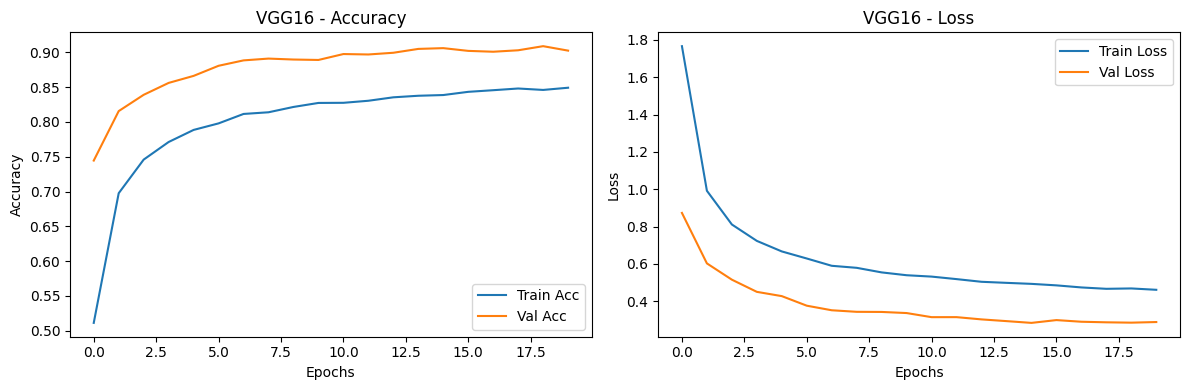

In [16]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_vgg.history['accuracy'], label='Train Acc')
plt.plot(history_vgg.history['val_accuracy'], label='Val Acc')
plt.title('VGG16 - Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_vgg.history['loss'], label='Train Loss')
plt.plot(history_vgg.history['val_loss'], label='Val Loss')
plt.title('VGG16 - Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [35]:
print("✅ VGG16 model successfully trained and saved.")


✅ VGG16 model successfully trained and saved.


### 🔍 **3. Grad-CAM Visualization for VGG16**


**- Comprendre visuellement pourquoi le modèle VGG16 fait une certaine prédiction**

**- Identifier les zones importantes de l’image qui influencent le modèle (ex : tache, contour de la feuille…)**



In [28]:
model_vgg.summary()
model_vgg.get_layer("vgg16").summary()
print("🧩 input:", model_vgg.input)
print("🎯 output:", model_vgg.output)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 38)                9766      
                                                                 
Total params: 14,855,782
Trainable params: 141,094
Non-trainable params: 14,714,688
____________________________________

In [33]:
import cv2
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import matplotlib.cm as cm

def get_gradcam_heatmap_vggonly(img_array, vgg_model, conv_layer_name='block5_conv3'):
    conv_layer = vgg_model.get_layer(conv_layer_name)
    grad_model = tf.keras.models.Model([vgg_model.input], [conv_layer.output])

    with tf.GradientTape() as tape:
        conv_outputs = grad_model(img_array)
        tape.watch(conv_outputs)
        output = tf.reduce_mean(conv_outputs, axis=[1, 2])

    grads = tape.gradient(output, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, model_vgg, conv_layer_name='block5_conv3'):
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # Extraire la sous-couche VGG16 depuis model_vgg
    vgg_model = model_vgg.get_layer('vgg16')

    # Générer la heatmap depuis la VGG16 uniquement
    heatmap = get_gradcam_heatmap_vggonly(img_array, vgg_model, conv_layer_name)
    heatmap = cv2.resize(heatmap, (img.size[0], img.size[1]))
    heatmap = np.uint8(255 * heatmap)
    jet = cm.get_cmap("jet") if hasattr(cm, 'get_cmap') else cm.get_cmap("jet")  # Compatibilité matplotlib 3.7+
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = image.array_to_img(jet_heatmap)
    jet_heatmap = np.array(jet_heatmap)

    superimposed_img = jet_heatmap * 0.4 + np.array(img)
    superimposed_img = image.array_to_img(superimposed_img)

    plt.figure(figsize=(6, 6))
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.title("Grad-CAM - VGG16")  # 🔥 retiré pour éviter erreur unicode
    plt.show()

C:\Users\cheri\AppData\Local\Temp\ipykernel_13256\1794334303.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap("jet") if hasattr(cm, 'get_cmap') else cm.get_cmap("jet")  # Compatibilité matplotlib 3.7+


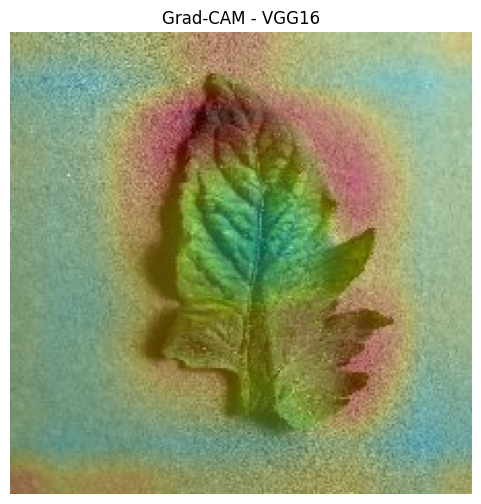

In [34]:
display_gradcam("data/split/test/Tomato___Tomato_mosaic_virus/0a91f50b-1263-4b2c-a8c1-f2a6025b82f3___PSU_CG 2136.JPG", model_vgg)
